# Optimization via Stochastic Gradient Descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

np.random.seed(42)

In [2]:
def sgd(loss, grad_loss, w0, data, batch_size, n_epochs, lr):
    X, y = data
    data_size = X.shape[1]
    curr_w = w0
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_loss(w0, X, y)]
    history_err = [np.linalg.norm(history_grad[-1], 2)]

    for _ in range(n_epochs):
        idxs = np.arange(0, data_size)
        np.random.shuffle(idxs)

        for i in range(math.ceil(data_size / batch_size)):
        # for i in range(data_size // batch_size):
            batch_idxs = idxs[i*batch_size : (i+1)*batch_size]
            batch_X = X[:, batch_idxs]
            batch_y = y[batch_idxs]

            curr_w = curr_w - lr*grad_loss(curr_w, batch_X, batch_y)

        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(grad_loss(curr_w, X, y))
        history_err.append( np.linalg.norm(history_grad[-1], 2) )

    return history_w, history_loss, history_grad, history_err

In [3]:
def backtracking(loss, grad_loss, w, data):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    X, y = data
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while loss(w - alpha * grad_loss(w, X, y), X, y) > loss(w, X, y) - c * alpha * np.linalg.norm(grad_loss(w, X, y), 2) ** 2:
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha


def gd(loss, grad_loss, w0, data, k_max, tol_loss, tol_w, alpha=None):
    X, y = data
    curr_w, prev_w = w0, np.inf
    curr_k = 0
    grad_x0, curr_grad = grad_loss(w0, X, y), grad_loss(curr_w, X, y)
    history_w = [w0]
    history_loss = [loss(w0, X, y)]
    history_grad = [grad_x0]
    history_err = [np.linalg.norm(grad_x0, 2)]
    use_backtracking = alpha is None

    while (curr_k < k_max and 
            not (np.linalg.norm(curr_grad, 2) < tol_loss*np.linalg.norm(grad_x0, 2)) and
            not (np.linalg.norm(curr_w - prev_w, 2) < tol_w)):
        if use_backtracking:
            alpha = backtracking(loss, grad_loss, curr_w, data)
        prev_w = curr_w
        curr_w = curr_w - alpha*grad_loss(curr_w, X, y)

        curr_grad = grad_loss(curr_w, X, y)
        curr_k += 1
        
        history_w.append(curr_w)
        history_loss.append(loss(curr_w, X, y))
        history_grad.append(curr_grad)
        history_err.append(np.linalg.norm(curr_grad, 2))

    return history_w, curr_k, history_loss, history_grad, history_err

In [35]:
def train_test_split(X, Y, train_size):
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test


def filterDigits(X, Y, digits):
    select_mask = np.full(Y.shape, False)
    for d in digits:
        select_mask = select_mask | (Y == d)
    
    return X[:, select_mask], Y[select_mask]


def onehot(Y_digits):
    digits = np.unique(Y_digits).tolist()
    return np.array([ [0]*((digits.index(d))) + [1] + [0]*((len(digits) - digits.index(d)-1)) for d in Y_digits ])


def createDataset(X, Y, digits, classification_type="binary", train_ratio=0.75):
    X, Y = filterDigits(X, Y, digits)

    if classification_type == "binary":
        Y[Y == digits[0]] = 0
        Y[Y == digits[1]] = 1
    elif classification_type == "multi":
        Y = onehot(Y)
    else: raise Exception("Invalid type")

    return train_test_split(X, Y, int(train_ratio*X.shape[1]))

In [5]:
def addColumn(A):
    out = np.ones((A.shape[0]+1, A.shape[1]))
    out[1:, :] = A
    return out

data = pd.read_csv("../homework2/data/data.csv")
data = data.to_numpy()

full_X = addColumn(data[:, 1:].T)
full_Y = data[:, 0].T
print(full_X.shape, full_Y.shape)

(785, 42000) (42000,)


## Binary classification

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(w, x):
    return sigmoid(x.T @ w)


def mse(fn, w, X, y):
    N = X.shape[1]
    return (1/(2*N)) * np.linalg.norm(fn(w, X) - y, 2)**2

def mse_grad(fn, w, X, y):
    N = X.shape[1]
    fn_X = fn(w, X)
    return (1/N) * ( X @ (fn_X * (1-fn_X) * (fn_X - y)) )


def loss(w, X, Y):
    return mse(f, w, X, Y)

def grad_loss(w, X, Y):
    return mse_grad(f, w, X, Y)

In [39]:
def evaluate(w, X_test, Y_test, threshold=0.5):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_prob = f(w, X_test[:, i])
        # print(f"{pred_prob:.2f}", end=" ")
        
        if pred_prob >= threshold:
            pred = 1
        else:
            pred = 0
            
        if pred == Y_test[i]:
            correct += 1

    return correct, correct / N

In [40]:
digits = [8, 9]
X_train, Y_train, X, Y = createDataset(full_X, full_Y, digits, classification_type="binary")
print("Train", (Y_train == 0).sum(), (Y_train == 1).sum())
print("Test", (Y == 0).sum(), (Y == 1).sum())

Train 3045 3143
Test 1018 1045



 0.9733397964129908


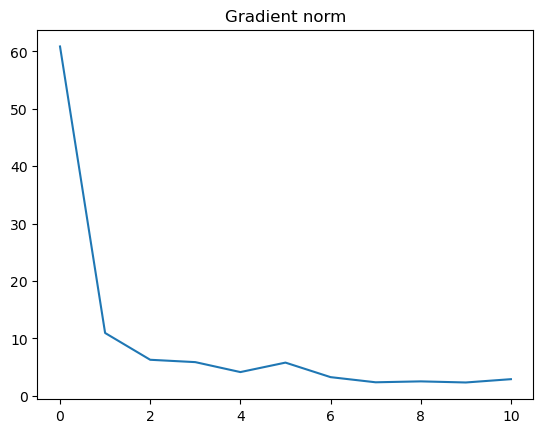

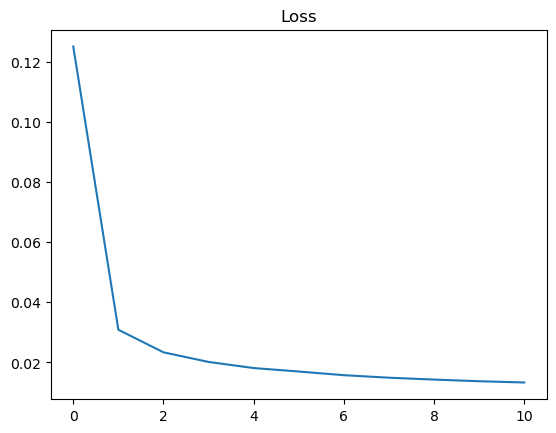

In [41]:
history_w, history_loss, history_grad, history_err = sgd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 500, 10, 1e-5)
# history_w, curr_k, history_loss, history_grad, history_err = gd(loss, grad_loss, np.zeros(X_train.shape[0]), (X_train, Y_train), 5, 1e-8, 1e-8)

correct, accuracy = evaluate(history_w[-1], X, Y)
print("\n", accuracy)

plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.show()

plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

In [10]:
class BinaryLogisticRegression:
    def __init__(self):
        self.w = None

    def fit(self, X_train, Y_train, algorithm="sgd", w0=None, batch_size=200, epochs=10, lr=1e-5, tol_loss=1e-8, tol_w=1e-8):
        if algorithm == "sgd":
            history_w, history_loss, history_grad, history_err = sgd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), 
                batch_size, epochs, lr
            )
        else:
            history_w, curr_k, history_loss, history_grad, history_err = gd(
                loss, grad_loss, 
                w0 if w0 is not None else np.zeros(X_train.shape[0]), 
                (X_train, Y_train), epochs, tol_loss, tol_w
            )
            
        self.w = history_w[-1]

    def predict(self, X, threshold=0.5):
        if X.ndim == 1:
            return 1 if f(self.w, X) >= threshold else 0
        else:
            out = []

            for i in range(X.shape[1]):
                out.append(1 if f(self.w, X[:, i]) >= threshold else 0)
            return np.array(out)        

In [11]:
def binaryDigitEvaluation(digit1, digit2):
    X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [digit1, digit2])

    model_sgd = BinaryLogisticRegression()
    model_gd = BinaryLogisticRegression()
    model_sgd.fit(X_train, Y_train, algorithm="sgd")
    model_gd.fit(X_train, Y_train, algorithm="gd")

    accuracy_sgd = np.sum(model_sgd.predict(X_test) == Y_test) / Y_test.shape[0]
    accuracy_gd = np.sum(model_gd.predict(X_test) == Y_test) / Y_test.shape[0]
    
    print(f"------ Classifying {digit1} {digit2} ------")
    print(f"||w_sgd - w_gd ||_2 = {np.linalg.norm(model_sgd.w - model_gd.w)}")
    print(f"SGD acc. = {accuracy_sgd} | GD acc. {accuracy_gd}")

binaryDigitEvaluation(0, 1)
binaryDigitEvaluation(8, 9)

/tmp/ipykernel_78281/3489188747.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


------ Classifying 0 1 ------
||w_sgd - w_gd ||_2 = 0.10964653336957088
SGD acc. = 0.9986388384754991 | GD acc. 0.9950090744101633
------ Classifying 8 9 ------
||w_sgd - w_gd ||_2 = 0.05214688355726132
SGD acc. = 0.9772176442074648 | GD acc. 0.9660688317983519


In [12]:
def trainModels(train_ratio):
    models_sgd = {}
    models_gd = {}

    for i in range(0, 10):
        for j in range(i, 10):
            X_train, Y_train, X_test, Y_test = createDataset(full_X, full_Y, [i, j], classification_type="binary", train_ratio=train_ratio)
            
            model_sgd = BinaryLogisticRegression()
            model_sgd.fit(X_train, Y_train, "sgd")
            models_sgd[(i,j)] = models_sgd[(j, i)] = (model_sgd, X_test, Y_test)

            model_gd = BinaryLogisticRegression()
            model_gd.fit(X_train, Y_train, "gd")
            models_gd[(i,j)] = models_gd[(j, i)] = (model_gd, X_test, Y_test)

    return models_sgd, models_gd


def accuracyHeatMapData(models):
    accuracies = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            if i == j: accuracies[i, j] = 1

            model, X_test, Y_test = models[(i, j)]
            accuracies[i, j] = accuracies[j, i] = np.sum(model.predict(X_test) == Y_test) / Y_test.shape[0]

    return accuracies


def paramsDiffHeatMapData(models_sgd, models_gd):
    differences = np.zeros((10, 10))

    for i in range(0, 10):
        for j in range(i, 10):
            model_sgd, _, _ = models_sgd[(i, j)]
            model_gd, _, _ = models_gd[(i, j)]
            differences[i, j] = differences[j, i] = np.linalg.norm(model_sgd.w - model_gd.w)

    return differences

/tmp/ipykernel_78281/3489188747.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


KeyboardInterrupt: 

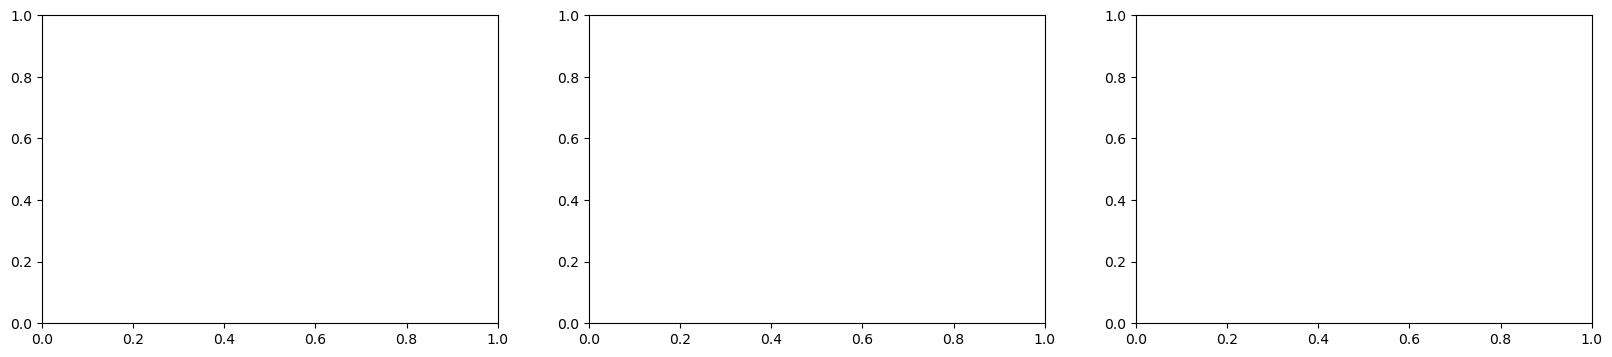

In [13]:
to_test_ratio = [0.95, 0.75, 0.5, 0.25, 0.01]

for i, ratio in enumerate(to_test_ratio):
    plt.figure(figsize=(20, 4))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)

    models_sgd, models_gd = trainModels(ratio)

    plt.suptitle(f"Train ratio: {ratio}")

    accuracies_sgd = accuracyHeatMapData(models_sgd)
    accuracies_gd = accuracyHeatMapData(models_gd)
    param_diffs = paramsDiffHeatMapData(models_sgd, models_gd)

    ax1.set_title(f"Accuracy SGD")
    sns.heatmap(accuracies_sgd, annot=True, ax=ax1, 
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=min(np.min(accuracies_sgd), np.min(accuracies_gd)), vmax=max(np.max(accuracies_sgd), np.max(accuracies_gd))
    )

    ax2.set_title(f"Accuracy GD")
    sns.heatmap(accuracies_gd, annot=True, ax=ax2, 
        cmap=sns.color_palette("flare", as_cmap=True), 
        vmin=min(np.min(accuracies_sgd), np.min(accuracies_gd)), vmax=max(np.max(accuracies_sgd), np.max(accuracies_gd))
    )
    
    ax3.set_title(f"SGD - GD parameters diff")
    sns.heatmap(param_diffs, annot=True, ax=ax3, cmap=sns.color_palette("flare", as_cmap=True))

    plt.show()

## Multi-class classification

\begin{equation}
    w: N \times 3
\end{equation}

\begin{split}
    MSE&: (N \times 3) \rightarrow 1 \\
    \nabla MSE&: (N \times 3) \rightarrow (N \times 3)
\end{split}

\begin{split}
    \sigma&: 3 \rightarrow 3 \\
    \nabla\sigma&: 3 \rightarrow (3 \times 3)
\end{split}

\begin{split}
    f&: (N \times 3) \rightarrow 3 \\
    \nabla f&: (N \times 3) \rightarrow (3 \times N \times 3)
\end{split}

In [46]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

def softmax_grad(z):
    # grad_matr = []
    # for i in range(z.shape[0]):
    #     grad_row = []
    #     for j in range(z.shape[0]):
    #         delta = 1 if i == j else 0
    #         grad_row.append( softmax(z)[i] * (delta - softmax(z)[j]) )
    #     grad_matr.append(grad_row)
    
    # return np.array(grad_matr)

    s = softmax(z)
    return np.diag(s) - np.outer(s, s)


def f_multi(w, x):
    return softmax(x.T @ w)

def f_multi_grad(w, x):
    def __grad(a):
        grad = softmax_grad(a.T @ w)
        out = np.array([ np.outer(a.T, grad[i, :]) for i in range(grad.shape[0]) ])
        return out
    
    if x.ndim == 1: return __grad(x)
    
    out = []
    for i_data in range(x.shape[1]):
        data = x[:, i_data]
        out.append(__grad(data))
        
    return np.array(out)
 

def mse(f, w, D):
    X, y = D
    N = X.shape[1]
    return (1/(2*N)) * (np.linalg.norm(f(w, X) - y, 2)**2)

def mse_grad(f, grad_f, w, D):
    X, y = D
    N = X.shape[1]
    grad = grad_f(w, X)
    f_x = f(w, X)

    out = []
    for i in range(N):
        grad_i = grad[i]
        f_x_i = f_x[i]
        y_i = y[i]
        out.append((1/N) * grad_i @ (f_x_i - y_i))

    return np.mean(np.array(out), axis=0).T


def loss_multi(w, X, Y):
    return mse(f_multi, w, (X, Y))

def grad_loss_multi(w, X, Y):
    return mse_grad(f_multi, f_multi_grad, w, (X, Y))

In [47]:
def evaluateMulti(w, X_test, Y_test):
    correct = 0
    N = X_test.shape[1]

    for i in range(N):
        pred_probs = f_multi(w, X_test[:, i])
        
        if np.argmax(pred_probs) == np.argmax(Y_test[i]):
            correct += 1

    return correct, correct / N

In [48]:
digits = [1, 8, 9]
X_train, Y_train, X, Y = createDataset(full_X, full_Y, digits, classification_type="multi")

for digit, train_size, test_size in zip([d for d in digits], np.sum(Y_train, axis=0), np.sum(Y, axis=0)):
    print(f"{digit} | {train_size} train -- {test_size} test")

1 | 3536 train -- 1148 test
8 | 3078 train -- 985 test
9 | 3087 train -- 1101 test


(3067, 0.948361162646877)


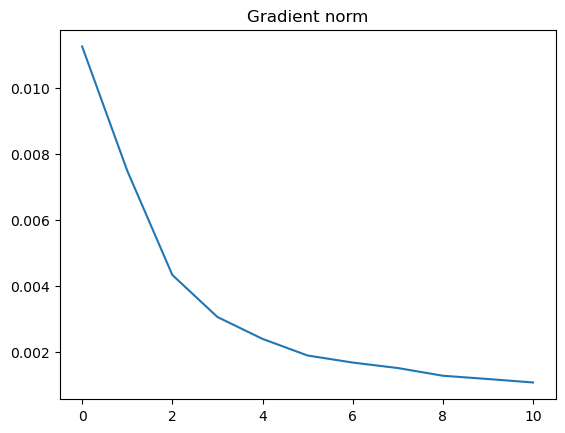

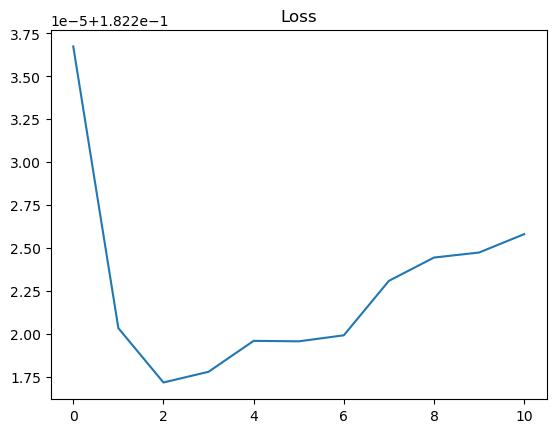

In [49]:
history_w, history_loss, history_grad, history_err = sgd(
    loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 500, 10, 5e-4
)
# history_w, curr_k, history_loss, history_grad, history_err = gd(
#     loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, Y_train), 5, 1e-8, 1e-8
# )

print(evaluateMulti(history_w[-1], X, Y))

plt.plot(range(len(history_err)), history_err)
plt.title("Gradient norm")
plt.show()

plt.plot(range(len(history_loss)), history_loss)
plt.title("Loss")
plt.show()

### PCA vs Logistic regression

In [53]:
class MNISTLogisticClassifier:
    def __init__(self):
        self.w = None
        self.digits = []

    def fit(self, X_train, Y_train, epochs=500, batch_size=10, lr=5e-4):
        self.digits = np.unique(Y_train).tolist()
        history_w, history_loss, history_grad, history_err = sgd(
            loss_multi, grad_loss_multi, np.zeros((X_train.shape[0], len(digits))), (X_train, onehot(Y_train)), epochs, batch_size, lr
        )
        self.w = history_w[-1]

    def predict(self, new_digit):
        preds = f_multi(self.w, new_digit)
        return self.digits[np.argmax(preds)]

In [58]:
def centroid(data):
    return np.expand_dims( np.mean(data, axis=1), 1 )

class PCA:
    def __init__(self):
        self.data_centroid = None
        self.proj_matrix = None

    def fit(self, data, k):
        self.data_centroid = centroid(data)
        centered_data = data - self.data_centroid

        U, _, _ = np.linalg.svd(centered_data, full_matrices=False)
        self.proj_matrix = U[:, :k].T

    def transform(self, data):
        if data.ndim == 1:
            data = np.expand_dims(data, axis=1)
            
        data_centered = data - self.data_centroid
        return self.proj_matrix @ data_centered
    
    def fit_transform(self, data, k):
        self.fit(data, k)
        return self.transform(data)


class MNISTPCAClassifier:
    def __init__(self):
        self.pca = None
        self.Z_k_train = None
        self.possible_digits = None
        self.digits_centroid = None

    def fit(self, X_train, Y_train, k=2):
        self.pca = PCA()
        self.Z_k_train = self.pca.fit_transform(X_train, k)
        self.possible_digits = np.unique(Y_train)
        self.digits_centroid = { digit: centroid(self.Z_k_train[:, Y_train == digit]) for digit in self.possible_digits }

    def predict(self, new_digit):
        Z_k_digit = self.pca.transform(new_digit)
        best_distance = +np.inf
        best_digit = None

        for digit in self.possible_digits:
            distance = np.linalg.norm(self.digits_centroid[digit] - Z_k_digit)
            if distance < best_distance:
                best_distance = distance
                best_digit = digit

        return best_digit

In [84]:
def accuracy(classifier, X, Y):
    correct = 0
    for i in range(X.shape[1]):
        pred = classifier.predict(X[:, i])
        if pred == Y[i]: correct += 1
    return correct / X.shape[1]

def buildDataset(X, Y, digits):
    X, Y = filterDigits(X, Y, digits)
    return train_test_split(X, Y, int(0.75*X.shape[1]))


X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, [0, 1, 8])

pca_classifier = MNISTPCAClassifier()
pca_classifier.fit(X_train, Y_train, k=10)
print(f"PCA                 accuracy: {accuracy(pca_classifier, X_test, Y_test)}")

logistic_classifier = MNISTLogisticClassifier()
logistic_classifier.fit(X_train, Y_train, epochs=20)
print(f"Logistic regression accuracy: {accuracy(logistic_classifier, X_test, Y_test)}")

PCA                 accuracy: 0.9444099378881987
Logistic regression accuracy: 0.987888198757764


In [107]:
pca_accuracies = {}
logistic_accuracies = {}

print(f"| {'Digits':^15} | {'PCA acc.':^25} | {'Logistic acc.':^25} | {'Best':^10} |")

for i in range(0, 10):
    for j in range(0, 10):
        for k in range(0, 10):
            if (len(set([i, j, k])) != 3) or (tuple(sorted([i, j, k])) in pca_accuracies): continue

            digits = tuple(sorted([i, j, k]))
            X_train, Y_train, X_test, Y_test = buildDataset(full_X, full_Y, digits)
            
            pca_classifier = MNISTPCAClassifier()
            pca_classifier.fit(X_train, Y_train, k=10)
            pca_accuracies[digits] = accuracy(pca_classifier, X_test, Y_test)

            logistic_classifier = MNISTLogisticClassifier()
            logistic_classifier.fit(X_train, Y_train, epochs=20)
            logistic_accuracies[digits] = accuracy(logistic_classifier, X_test, Y_test)

            if pca_accuracies[digits] > logistic_accuracies[digits]:
                best = "PCA" 
            elif logistic_accuracies[digits] > pca_accuracies[digits]:
                best = "Logistic"
            else: best = "---"
            print(f"| {str(sorted([i, j, k])):^15} | {pca_accuracies[digits]:^25.4f} | {logistic_accuracies[digits]:^25.4f} | {best:^10} |")

|     Digits      |         PCA acc.          |       Logistic acc.       |    Best    |
|    [0, 1, 2]    |          0.9381           |          0.9858           |  Logistic  |
|    [0, 1, 3]    |          0.9526           |          0.9875           |  Logistic  |
|    [0, 1, 4]    |          0.9699           |          0.9947           |  Logistic  |
|    [0, 1, 5]    |          0.9210           |          0.9870           |  Logistic  |
|    [0, 1, 6]    |          0.9500           |          0.9926           |  Logistic  |
|    [0, 1, 7]    |          0.9616           |          0.9946           |  Logistic  |
|    [0, 1, 8]    |          0.9388           |          0.9826           |  Logistic  |
|    [0, 1, 9]    |          0.9677           |          0.9911           |  Logistic  |
|    [0, 2, 3]    |          0.9182           |          0.9709           |  Logistic  |
|    [0, 2, 4]    |          0.9451           |          0.9861           |  Logistic  |
|    [0, 2, 5]    |  